# Algorithms for massive datasets & Statistical methods for ML: Joint Project 2022-23

This notebook serves as the primary document for the joint project combining the subjects of "Algorithms for massive datasets" and "Statistical methods for ML" for the academic year 2022-23.

The core objective of this project is to delve deep into the domain of transaction analysis, especially focusing on the identification of money laundering activities. The dataset in focus for this project is the "IBM Transactions for Anti Money Laundering" dataset, sourced from Kaggle. This dataset comprises multiple CSV files, each with varying data sizes and frequencies of illicit transactions. The challenge is to implement an efficient system capable of predicting illicit transactions.

### Disclaimer

I declare that this material, which I now submit for assessment, is entirely my own work and has not been taken from the work of others, save and to the extent that such work has been cited and acknowledged within the text of my work. I understand that plagiarism, collusion, and copying are grave and serious offences in the university and accept the penalties that would be imposed should I engage in plagiarism, collusion or copying. This assignment, or any part of it, has not been previously submitted by me/us or any other person for assessment on this or any other course of study.

## API Kaggle

Come prima cosa è necessario scaricare il file .kaggle.json. Per ottenerlo visita il tuo profilo Kaggle e vai alla sezione [Account](https://www.kaggle.com/settings/account). Scendi fino a trovare la sezione 'API' e premi su 'Create New Token' per scaricare il file .kaggle.json.


# Setup dell'environment

Prima di iniziare a lavorare sui dati, ci sono dei passaggi da fare per ottenere l'accesso a Kaggle per scaricare i datasets.

Fatto ciò, esegui il seguente codice per caricare il file .kaggle.json:

In [ ]:
from google.colab import files
files.upload()  # This will prompt you to upload the kaggle.json

!mkdir -p ~/.kaggle
!cp kaggle.json ~/.kaggle/
!chmod 600 ~/.kaggle/kaggle.json  # Change the permissions of the file.

Saving kaggle.json to kaggle.json


## Download e unzip dei datasets

A questo punto è possibile andare a scaricare i dataset direttamente nell'ambiente Colab. I file verranno salvati in una cartella creata appositamente.

In [ ]:
# Creazione della cartella
!mkdir -p datasets

# Installa le librerie necessarie per kaggle
!pip install kaggle

# Scarica il dataset
!kaggle datasets download -d ealtman2019/ibm-transactions-for-anti-money-laundering-aml -p datasets/

# Estrai il dataset zippato
%cd datasets
!unzip ibm-transactions-for-anti-money-laundering-aml.zip

# Elimina lo zip
!rm ibm-transactions-for-anti-money-laundering-aml.zip
%cd ..

100% 7.40G/7.42G [01:24<00:00, 125MB/s]
100% 7.42G/7.42G [01:24<00:00, 94.4MB/s]
/content/datasets
Archive:  ibm-transactions-for-anti-money-laundering-aml.zip
  inflating: HI-Large_Patterns.txt   
  inflating: HI-Large_Trans.csv      
  inflating: HI-Medium_Patterns.txt  
  inflating: HI-Medium_Trans.csv     
  inflating: HI-Small_Patterns.txt   
  inflating: HI-Small_Trans.csv      
  inflating: LI-Large_Patterns.txt   
  inflating: LI-Large_Trans.csv      
  inflating: LI-Medium_Patterns.txt  
  inflating: LI-Medium_Trans.csv     
  inflating: LI-Small_Patterns.txt   
  inflating: LI-Small_Trans.csv      
/content


## Installazione e importazione delle librerie principali

Uno dei due punti principali del progetto è quello di andare ad utilizzare spark per creare un random forest costituito da alberi creati su diversi worker. Oltre che per il random forest però, andremo ad utilizzare spark anche per gestire tutta la parte di analisi e rilevazione delle features all'interno dei dati.

In [1]:
!pip install pyspark

from pyspark.sql import SparkSession

import pandas as pd
import numpy as np
import tqdm
from pyspark.sql.window import Window
from sklearn.preprocessing import LabelEncoder
from pyspark.sql.functions import *
from pyspark.sql import SparkSession
from pyspark import SparkContext
from pyspark.sql.types import *
import multiprocessing
from pyspark.ml.feature import StringIndexer
from pyspark.ml.feature import VectorAssembler
from pyspark.ml.stat import Correlation
import seaborn as sns
import matplotlib.pyplot as plt
from pyspark.sql import functions as F
import os
import shutil
from collections import Counter
import math
from sklearn.metrics import f1_score
import gc

### Configurazione spark

Per funzionare al meglio spark necessita di avere a disposizione più memoria e potenza di calcolo possibile. Per questo motivo è necessario andare a configurare i parametri manualmente per far si che possa sfruttare a pieno la potenza di calcolo della macchina su cui gira.

Per l'esecuzione su colab sono stati utilizzati questi valori:

**Spark Driver Memory:** 6g

**Spark Executor Memory:** 4g

In [4]:
spark_driver_memory = "3g"
spark_executor_memory = "4g"
spark_partial_results_folder = './partial_results'
spark_processed_results_folder = './processed_data'

spark = SparkSession.builder \
                    .config("spark.driver.memory", spark_driver_memory) \
                    .config("spark.executor.memory", spark_executor_memory) \
                    .master("local[*]") \
                    .config("spark.sql.autoBroadcastJoinThreshold", 100 * 1024 * 1024)\
                    .config("spark.driver.port", 4040) \
                    .config("spark.driver.bindAddress", "127.0.0.1") \
                    .getOrCreate()
print("Spark session created")
sc = spark.sparkContext
print("Spark context created")


if not os.path.exists(spark_partial_results_folder):
    os.makedirs(spark_partial_results_folder)
if not os.path.exists(spark_processed_results_folder):
    os.makedirs(spark_processed_results_folder)

Spark session created
Spark context created


In [3]:
skip_boruta = False
skip_hyperparameter_tuning = False
df_type = 'small'

In [5]:
def skip_cell_if(condition):
    """Skip execution of the current cell if condition is True."""
    if condition:
        get_ipython().run_cell_magic('javascript', '', 'IPython.notebook.execute_cell()')

get_ipython().register_magic_function(skip_cell_if, magic_kind='line')

# Exploratory data analysis

Il file zip scaricato da Kaggle contiene tre dataset distinti divisi in Short, Medium e Large size. Per ogni dimensione sono presenti due versioni, una con la dicitura HI e una con la dicitura LI le quali indicano un'alta e una bassa presenza di transazioni fraudolente rispettivamente.

Oltre ai dataset sono presenti anche dei file .txt aggiuntivi che mostrano i pattern fraudolenti con le relative transazioni all'interno dei dataset. I pattern che vengono mostrati sono spiegati in maniera più approfondita in questo [paper](https://arxiv.org/pdf/2306.16424.pdf) e sono 8:

*   Cicli
*   Fan-In
*   Fan-Out
*   Scatter-Gather
*   Gather-Scatter
*   Bipartite
*   Stack
*   Random

Per svolgere le analisi sui dati è stato utilizzato il dataset HI-Small che, grazie alla sua dimensione ridotta, permette di eseguire analisi e statistiche in minor tempo, considerando anche le statistiche hardware limitate.



## Load data

In [8]:
# Definition of the schema for reading the file
schema = StructType([
    StructField('timestamp', StringType(), True),
    StructField('from_bank', IntegerType(), True),
    StructField('from_account', StringType(), True),
    StructField('to_bank', IntegerType(), True),
    StructField('to_account', StringType(), True),
    StructField('amount_received', FloatType(), True),
    StructField('receiving_currency', StringType(), True),
    StructField('amount_paid', FloatType(), True),
    StructField('payment_currency', StringType(), True),
    StructField('payment_format', StringType(), True),
    StructField('is_laundering', IntegerType(), True)])

# Reading the csv file directly in spark
if df_type == 'small':
    df = spark.read.csv("./datasets/HI-Small_Trans.csv", header = False, schema=schema)
elif df_type == 'medium':
    df = spark.read.csv("./datasets/HI-Medium_Trans.csv", header = False, schema=schema)

# Removing the first row as it contains the csv header
df = df.filter(col('timestamp') != "Timestamp")

# Adding a unique ID for the rows.
df = df.withColumn("index", monotonically_increasing_id())

df.show(5, truncate=False)
df.printSchema()

+----------------+---------+------------+-------+----------+---------------+------------------+-----------+----------------+--------------+-------------+-----+
|timestamp       |from_bank|from_account|to_bank|to_account|amount_received|receiving_currency|amount_paid|payment_currency|payment_format|is_laundering|index|
+----------------+---------+------------+-------+----------+---------------+------------------+-----------+----------------+--------------+-------------+-----+
|2022/09/01 00:20|10       |8000EBD30   |10     |8000EBD30 |3697.34        |US Dollar         |3697.34    |US Dollar       |Reinvestment  |0            |0    |
|2022/09/01 00:20|3208     |8000F4580   |1      |8000F5340 |0.01           |US Dollar         |0.01       |US Dollar       |Cheque        |0            |1    |
|2022/09/01 00:00|3209     |8000F4670   |3209   |8000F4670 |14675.57       |US Dollar         |14675.57   |US Dollar       |Reinvestment  |0            |2    |
|2022/09/01 00:02|12       |8000F5030   

The data analysis will be divided into several parts:
Initially, an analysis will be conducted independently of the temporal order, focusing mainly on understanding the structure of the dataset, the proportions between laundering and non-laundering, and whether there are marked differences between the features of the two classes.
Subsequently, the temporal relationship between the data will be explored in more depth, given that time is one of the main features when trying to uncover fraudulent patterns.
Finally, after calculating the features that are believed to be of interest, the correlation matrix will be computed to understand how correlated the features are within the dataset and to also grasp their importance for the model's learning.

## Initial Analysis of the Dataset

In this section, we will look at how the classes are distributed within the dataset, studying the proportion of fraudulent transactions for different payment methods and formats, as well as the difference, if any, in the amounts being transferred when transactions are fraudulent.

In [9]:
# Check if there are any null values in any cell
df.select([F.sum(col(c).isNull().cast("int")).alias(c) for c in df.columns]).show()

+---------+---------+------------+-------+----------+---------------+------------------+-----------+----------------+--------------+-------------+-----+
|timestamp|from_bank|from_account|to_bank|to_account|amount_received|receiving_currency|amount_paid|payment_currency|payment_format|is_laundering|index|
+---------+---------+------------+-------+----------+---------------+------------------+-----------+----------------+--------------+-------------+-----+
|        0|        0|           0|      0|         0|              0|                 0|          0|               0|             0|            0|    0|
+---------+---------+------------+-------+----------+---------------+------------------+-----------+----------------+--------------+-------------+-----+



There are no null values, so there is no need to remove or modify any rows. Therefore, we can proceed with the subsequent analyses.

In [10]:
# Proportion of laundering and non-laundering within the dataset. 1: Laundering, 0: Not laundering
total_count = df.count()
df.select('is_laundering').groupBy('is_laundering').agg(count('*').alias('count')).withColumn("proportion", col('count')/total_count).show(5, truncate=False)

+-------------+-------+---------------------+
|is_laundering|count  |proportion           |
+-------------+-------+---------------------+
|1            |5177   |0.0010194266045335635|
|0            |5073168|0.9989805733954664   |
+-------------+-------+---------------------+



From the outset, it is evident that fraudulent transactions are approximately 1/1000 of the total transactions. This leads to a highly imbalanced dataset, making the identification of patterns more challenging.

### Display payment format in relation to laundering transaction

+--------------+----+-------+----------+
|payment_format|1   |0      |proportion|
+--------------+----+-------+----------+
|ACH           |4483|596314 |0.007518  |
|Bitcoin       |56  |146035 |0.000383  |
|Cash          |108 |490783 |0.000220  |
|Cheque        |324 |1864007|0.000174  |
|Credit Card   |206 |1323118|0.000156  |
|Reinvestment  |0   |481056 |0.000000  |
|Wire          |0   |171855 |0.000000  |
+--------------+----+-------+----------+



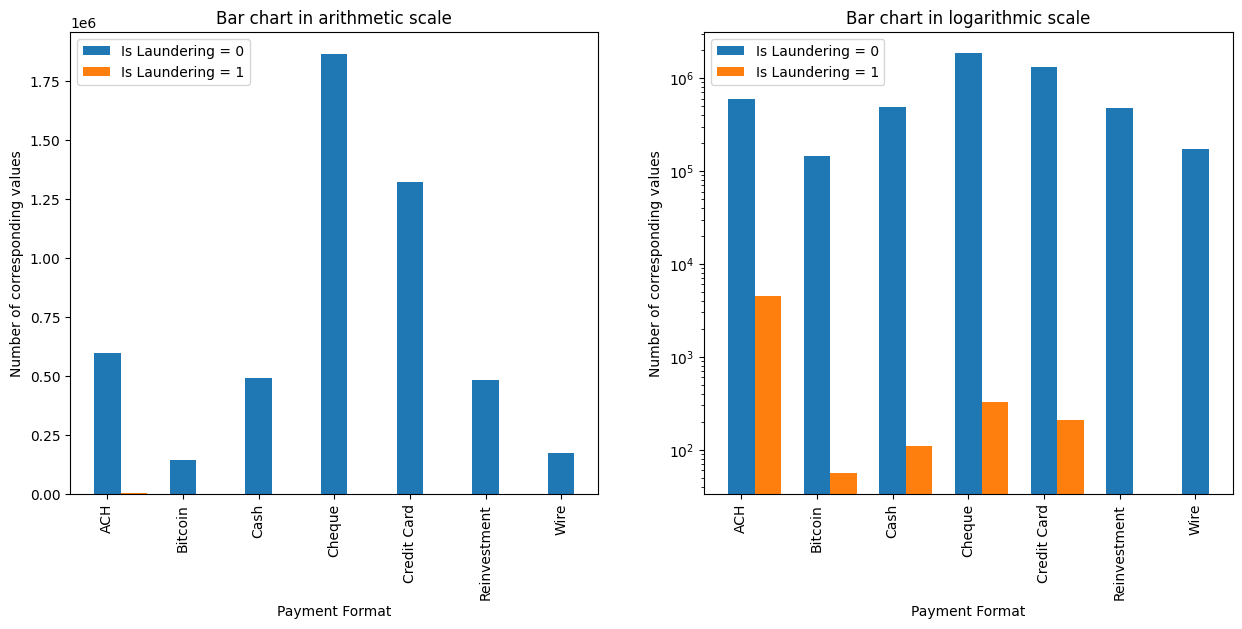

In [11]:
df.select('payment_format', 'is_laundering') \
    .groupBy('payment_format') \
    .agg(
        sum(col('is_laundering').cast('int')).alias('1'),
        sum((1 - col('is_laundering')).cast('int')).alias('0')
    ) \
    .withColumn("proportion", (col("1") / col("0")).cast('Decimal(20,6)')) \
    .orderBy('proportion', ascending=False) \
    .show(truncate=False)

if df_type == 'small':
    # Calculate the number of corresponding values for each value of the "Payment Format" and "Is Laundering" columns
    grouped_df = df.groupBy("payment_format", "is_laundering").count()

    count_values = grouped_df.toPandas()
    count_values_payment = count_values.pivot(index='payment_format', columns='is_laundering', values='count')


    fig, axs = plt.subplots(1, 2, figsize=(15, 6))
    bar_width = 0.35
    bar_positions = range(len(count_values_payment.index))

    #Arithmetic scale
    axs[0].bar(bar_positions, count_values_payment[0], bar_width, label='Is Laundering = 0')
    axs[0].bar([p + bar_width for p in bar_positions], count_values_payment[1], bar_width, label='Is Laundering = 1')
    axs[0].set_xticks(bar_positions)
    axs[0].set_xticklabels(count_values_payment.index, rotation='vertical')
    axs[0].set_xlabel('Payment Format')
    axs[0].set_ylabel('Number of corresponding values')
    axs[0].set_title('Bar chart in arithmetic scale')
    axs[0].legend()

    #Logaritmic scale
    axs[1].bar(bar_positions, count_values_payment[0], bar_width, label='Is Laundering = 0')
    axs[1].bar([p + bar_width for p in bar_positions], count_values_payment[1], bar_width, label='Is Laundering = 1')
    axs[1].set_xticks(bar_positions)
    axs[1].set_xticklabels(count_values_payment.index, rotation='vertical')
    axs[1].set_xlabel('Payment Format')
    axs[1].set_ylabel('Number of corresponding values')
    axs[1].set_title('Bar chart in logarithmic scale')
    axs[1].legend()
    axs[1].set_yscale('log')

    # Show the chart
    plt.show()

The analysis on the payment format in relation to laundering transactions clearly shows that the ACH payment method is often associated with a fraudulent transaction. Even more interestingly, the Reinvestment and Wire methods do not contain any fraudulent transactions. This immediately suggests that the payment format is an essential feature to consider, as on its own, if used with a tree-based model, it should be able to correctly classify all Reinvestment and Wire transactions.

### Display payment currency in relation to laundering transaction

+-----------------+----+-------+----------+
|payment_currency |1   |0      |proportion|
+-----------------+----+-------+----------+
|Saudi Riyal      |374 |88640  |0.004219  |
|Euro             |1372|1166925|0.001176  |
|US Dollar        |1912|1893260|0.001010  |
|Yen              |155 |155054 |0.001000  |
|Australian Dollar|127 |136642 |0.000929  |
|Canadian Dollar  |128 |139914 |0.000915  |
|Rupee            |167 |190035 |0.000879  |
|Yuan             |184 |213568 |0.000862  |
|Ruble            |133 |155045 |0.000858  |
|Mexican Peso     |92  |110067 |0.000836  |
|Swiss Franc      |193 |234667 |0.000822  |
|Brazil Real      |57  |70646  |0.000807  |
|UK Pound         |132 |180606 |0.000731  |
|Shekel           |95  |192089 |0.000495  |
|Bitcoin          |56  |146010 |0.000384  |
+-----------------+----+-------+----------+



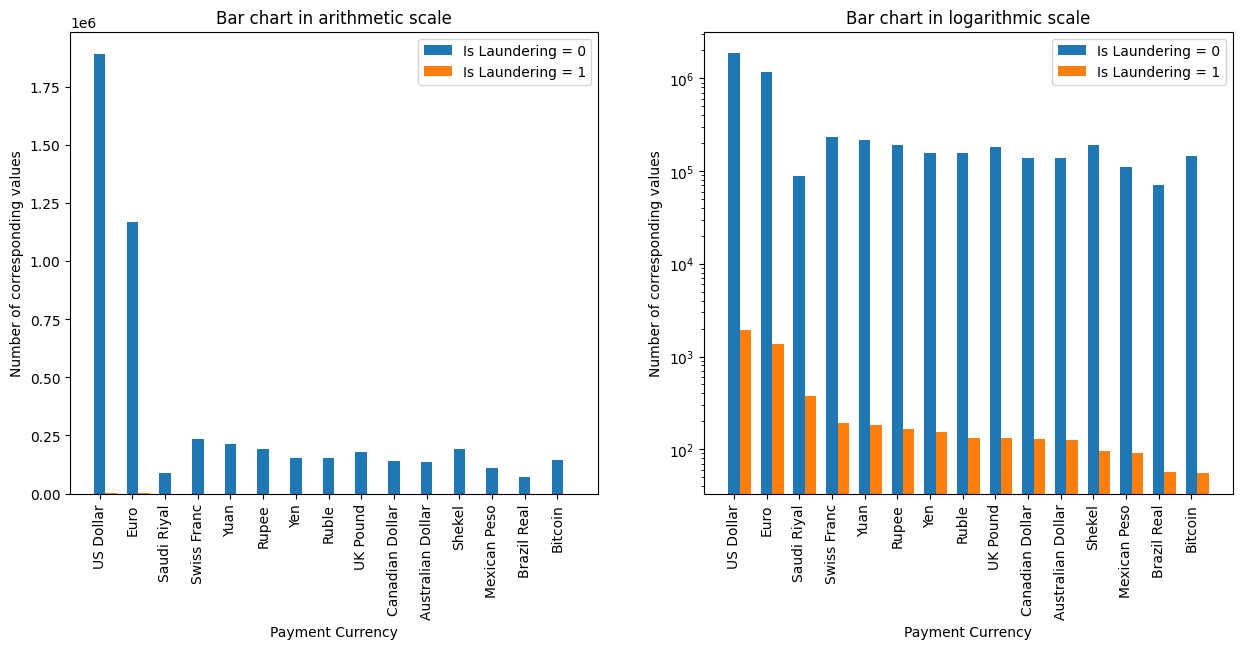

In [12]:
df.select('payment_currency', 'is_laundering') \
    .groupBy('payment_currency') \
    .agg(
        sum(col('is_laundering').cast('int')).alias('1'),
        sum((1 - col('is_laundering')).cast('int')).alias('0')
    ) \
    .withColumn("proportion", (col("1") / col("0")).cast('Decimal(20,6)')) \
    .orderBy('proportion', ascending=False) \
    .show(truncate=False)

if df_type == 'small':
    grouped_df = df.groupBy("payment_currency", "is_laundering").count()

    count_values = grouped_df.toPandas()
    count_values_currency = count_values.pivot(index='payment_currency', columns='is_laundering', values='count')
    count_values_currency = count_values_currency.sort_values(1, ascending=False)

    # Create a bar chart with a arithmetic scale
    fig, axs = plt.subplots(1, 2, figsize=(15, 6))
    bar_width = 0.35
    bar_positions = range(len(count_values_currency.index))
    axs[0].bar(bar_positions, count_values_currency[0], bar_width, label='Is Laundering = 0')
    axs[0].bar([p + bar_width for p in bar_positions], count_values_currency[1], bar_width, label='Is Laundering = 1')
    axs[0].set_xticks(bar_positions)
    axs[0].set_xticklabels(count_values_currency.index, rotation='vertical')
    axs[0].set_xticklabels(count_values_currency.index)
    axs[0].set_xlabel('Payment Currency')
    axs[0].set_ylabel('Number of corresponding values')
    axs[0].set_title('Bar chart in arithmetic scale')
    axs[0].legend()

    # Create a bar chart with a logarithmic scale
    axs[1].bar(bar_positions, count_values_currency[0], bar_width, label='Is Laundering = 0')
    axs[1].bar([p + bar_width for p in bar_positions], count_values_currency[1], bar_width, label='Is Laundering = 1')
    axs[1].set_xticks(bar_positions)
    axs[1].set_xticklabels(count_values_currency.index, rotation='vertical')
    axs[1].set_xticklabels(count_values_currency.index)
    axs[1].set_xlabel('Payment Currency')
    axs[1].set_ylabel('Number of corresponding values')
    axs[1].set_title('Bar chart in logarithmic scale')
    axs[1].legend()
    axs[1].set_yscale('log')


    plt.show()

The study on payment methods in relation to fraudulent transactions appears to be less impactful than that on the payment format. However, in the small dataset, it shows that the US Dollar payment type, which seems to be the most frequent within the dataset, contains the highest number of fraudulent transactions. Despite this, in terms of proportion, the Saudi Riyal payment method seems to be much more fraudulent, followed by the Euro.

### Display relationhip between amount paid and laundering transaction

+-------------+--------+-------------+-------------------+
|is_laundering|     min|          max|               mean|
+-------------+--------+-------------+-------------------+
|            1|0.003227| 8.4853146E10|3.613531071586281E7|
|            0|0.000001|1.04630236E12|  4477000.057857962|
+-------------+--------+-------------+-------------------+



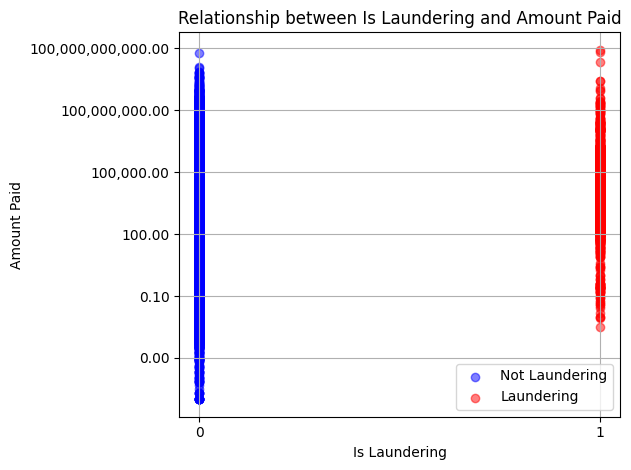

In [13]:
grouped_stats = df.groupBy('is_laundering').agg(
    min(col('amount_paid')).alias('min').cast('Decimal(20,6)').alias('min'),
    max(col('amount_paid')).alias('max').alias('max'),
    mean(col('amount_paid')).alias('mean').alias('mean')
)

grouped_stats.show()

if df_type == 'small':
    # Downsample the majority class since displaying would be too computationally intensive
    df_0 = df.filter(df['is_laundering'] == 0).sample(withReplacement=False, fraction=100000/5000000)
    df_1 = df.filter(df['is_laundering'] == 1)
    df_sampled = df_0.union(df_1)

    df_pd = df_sampled.toPandas()

    plt.yscale("log")
    plt.gca().yaxis.set_major_formatter(plt.FuncFormatter(lambda x, _: format(x, ',.2f')))

    # Plot the points for is_laundering == 0 in blue and is_laundering == 1 in red
    plt.scatter(df_pd[df_pd['is_laundering'] == 0]['is_laundering'], df_pd[df_pd['is_laundering'] == 0]['amount_paid'], color='blue', alpha=0.5, label='Not Laundering')
    plt.scatter(df_pd[df_pd['is_laundering'] == 1]['is_laundering'], df_pd[df_pd['is_laundering'] == 1]['amount_paid'], color='red', alpha=0.5, label='Laundering')

    plt.title("Relationship between Is Laundering and Amount Paid")
    plt.xlabel("Is Laundering")
    plt.ylabel("Amount Paid")
    plt.xticks([0, 1])
    plt.legend()
    plt.grid(True)
    plt.tight_layout()
    plt.show()


Unlike previous analyses, when examining the behavior of fraudulent transactions in relation to the amount sent, it is apparent that there is no clear separation between fraudulent and non-fraudulent transactions. In fact, using a chart, it can be observed that the range of amounts for fraudulent transactions is encompassed within non-fraudulent ones without a distinct divide. Moreover, considering that fraudulent transactions are about 1/1000 of non-fraudulent ones, it can be inferred that the transaction amount, whether tainted or not, likely does not significantly aid the model's ability to correctly classify the data.

However, these two features will be retained to examine them further in the correlation matrix.

### Display top 10 accounts for fraudolent transactions

In [14]:
# Calculate the total number of transactions for each account
total_transactions = df.groupBy('from_account')\
    .agg(F.count('*').alias('total_trans'))

# Count the number of fraudulent transactions for each account
fraudulent_transactions = df.filter(col('is_laundering') == 1)\
    .groupBy('from_account')\
    .agg(F.count('*').alias('count_laundering'))

# Merge the two counts
joined_df = total_transactions.join(fraudulent_transactions, 'from_account', 'left_outer')\
    .fillna(0)  # In case there are no fraudulent transactions for a given account

# Calculate the ratio
joined_df = joined_df.withColumn('fraud_rate', (F.col('count_laundering') / F.col('total_trans')).cast('Decimal(20,6)'))

# Sort and display the results
joined_df.orderBy('total_trans', ascending=False).show(10)
print(f"Number of accounts that send just one transaction and it is fraudulent: {joined_df.filter((col('total_trans') == 1) & (col('fraud_rate') == 1)).count()}")


+------------+-----------+----------------+----------+
|from_account|total_trans|count_laundering|fraud_rate|
+------------+-----------+----------------+----------+
|   100428660|     168672|             243|  0.001441|
|   1004286A8|     103018|             158|  0.001534|
|   100428978|      20497|              29|  0.001415|
|   1004286F0|      18663|              21|  0.001125|
|   100428780|      17264|              21|  0.001216|
|   1004289C0|      16794|              13|  0.000774|
|   100428810|      16426|              26|  0.001583|
|   1004287C8|      14174|              16|  0.001129|
|   100428738|      13756|              23|  0.001672|
|   100428A51|      13073|              18|  0.001377|
+------------+-----------+----------------+----------+
only showing top 10 rows



Number of accounts that send just one transaction and it is fraudulent: 122


### Determine how many times an account sends both laundering and non-laundering transactions to the same account.

In [15]:
df_temp = df.select('from_account', 'to_account', 'is_laundering')

# Group and count unique occurrences
grouped_df = df_temp.groupBy('from_account', 'to_account').agg(collect_set('is_laundering').alias('unique_values'))

# Filter results with more than one occurrence
filtered_df = grouped_df.filter(col('unique_values').getItem(0) != col('unique_values').getItem(1))

# Calculate the number of filtered occurrences for each 'from_account'
result_df = filtered_df.groupBy('from_account').count().orderBy(col('count').desc())

result_df.show(10)

+------------+-----+
|from_account|count|
+------------+-----+
|   100428660|  236|
|   1004286A8|  156|
|   100428978|   28|
|   100428810|   26|
|   100428738|   22|
|   1004286F0|   21|
|   100428780|   21|
|   100428A51|   18|
|   1004288A0|   16|
|   1004287C8|   16|
+------------+-----+
only showing top 10 rows



Regarding the accounts, it is evident that some accounts have conducted significantly more transactions than others. Apart from this, using accounts as features is not relevant for training the model. However, we can study the behavior of transactions when accounts are the same or different and determine if there's a particular correlation with fraudulent transactions. The same can be done with the sending and arriving currency and with the starting and arriving amount.

### Show the relationship between identical accounts and fraudulent transactions

In [16]:
grouped_df = df.filter(F.col('from_account') == F.col('to_account'))\
    .groupBy('is_laundering')\
    .agg(F.count('*').alias('count'))

count_total = df.groupBy(col('is_laundering').alias('is_laundering_temp')).agg(count('*').alias('count_total'))
grouped_df = grouped_df.join(count_total, col('is_laundering') == col('is_laundering_temp')).drop('is_laundering_temp').withColumn('proportion', (col('count') / col('count_total')).cast('Decimal(20,6)')).drop('count_total')
grouped_df.show()

+-------------+------+----------+
|is_laundering| count|proportion|
+-------------+------+----------+
|            1|    11|  0.002125|
|            0|591201|  0.116535|
+-------------+------+----------+



In [17]:
del result_df, joined_df, grouped_df
gc.collect()

70

From these analyses, it appears very unlikely that a transaction with the same source and destination account is fraudulent. This could prove to be an interesting feature to consider and add.

In [5]:
class Manager():

    """
    A class designed to manage and process dataframe features.
    """

    def __init__(self):
        """Initialize mappings for currency and payment format."""
        self.mapping_currency = {}
        self.mapping_format = {}
        self.mapping_account = {}

    def add_same_currency(self, df):
        """Add a column indicating if the receiving and payment currencies are the same."""
        return df.withColumn('same_currency', when((col('receiving_currency') == col('payment_currency')), 1).otherwise(0))

    def add_same_account(self, df):
        """Add a column indicating if the source and destination accounts are the same."""
        return df.withColumn('same_account', when((col('from_account') == col('to_account')), 1).otherwise(0))

    def add_same_bank(self, df):
        """Add a column indicating if the source and destination banks are the same."""
        return df.withColumn('same_bank', when((col('from_bank') == col('to_bank')), 1).otherwise(0))

    def add_trans_received(self, df):
        """Add columns showing the number of transactions received by an account per day, hour, and minute."""
        window = Window.partitionBy('to_account', 'day')
        df = df.withColumn("transaction_received_per_day", count('*').over(window))

        window = Window.partitionBy('to_account', 'hour')
        df = df.withColumn("transaction_received_per_hour", count('*').over(window))

        window = Window.partitionBy('to_account', 'minute')
        df = df.withColumn("transaction_received_per_minute", count('*').over(window))

        return df

    def add_trans_send(self, df):
        """Add columns showing the number of transactions sent by an account per day, hour, and minute."""
        window = Window.partitionBy('from_account', 'day')
        df = df.withColumn("transaction_send_per_day", count('*').over(window))

        window = Window.partitionBy('from_account', 'hour')
        df = df.withColumn("transaction_send_per_hour", count('*').over(window))

        window = Window.partitionBy('from_account', 'minute')
        df = df.withColumn("transaction_send_per_minute", count('*').over(window))

        return df

    def add_unique_payment_format(self, df):
        """Add a column indicating the number of unique payment formats an account has used in the last day."""
        df = df.withColumn("timestamp_minutes", F.unix_timestamp("timestamp")/60)

        #Day
        windowSpec = Window.partitionBy("from_account").orderBy("timestamp_minutes")\
                    .rangeBetween(-1440, Window.currentRow)
        df = df.withColumn("unique_payment_formats_last_day", F.size(F.collect_set("payment_format").over(windowSpec)))

        return df.drop('timestamp_minutes')

    def add_minutes_since_last_trans(self, df):
        """Add a column showing the number of minutes since the last transaction for each account."""
        windowSpec = Window.partitionBy("from_account").orderBy("timestamp")

        df = df.withColumn("prev_timestamp", F.lag(df.timestamp).over(windowSpec))

        # Calcola la differenza in minuti, -1 se è la prima transazione che effettua
        df = df.withColumn(
            "minutes_since_last_transaction",
            F.when(
                F.isnull(df.prev_timestamp),
                -1
            ).otherwise(
                (F.unix_timestamp(df.timestamp) - F.unix_timestamp(df.prev_timestamp)) / 60
            )
        )

        return df.drop("prev_timestamp")

    def add_unique_to_bank_account(self, df):
        """Add columns indicating the number of unique banks and accounts an account has transacted with in the last day."""
        df = df.withColumn("timestamp_minutes", F.unix_timestamp("timestamp")/60)

        windowSpec = Window.partitionBy("from_account").orderBy("timestamp_minutes")\
                    .rangeBetween(-1440, Window.currentRow)
        df = df.withColumn("unique_to_banks_last_day", F.size(F.collect_set("to_bank").over(windowSpec)))
        df = df.withColumn("unique_to_accounts_last_day", F.size(F.collect_set("to_account").over(windowSpec)))


        return df.drop('timestamp_minutes')

    def add_unique_payment_currency(self, df):
        """Add a column indicating the number of unique payment currencies an account has used in the last day."""
        df = df.withColumn("timestamp_minutes", F.unix_timestamp("timestamp")/60)

        windowSpec = Window.partitionBy("from_account").orderBy("timestamp_minutes")\
                    .rangeBetween(-1440, Window.currentRow)
        df = df.withColumn("unique_payment_currency_last_day", F.size(F.collect_set("payment_currency").over(windowSpec)))

        return df.drop('timestamp_minutes')

    def add_transaction_recurrence(self, df):
        """Add a column showing how often an account transacts with another specific account."""
        windowSpec = Window.partitionBy("from_account", "to_account").orderBy("timestamp").rowsBetween(Window.unboundedPreceding, Window.currentRow)
        return df.withColumn("transaction_recurrence", F.count("timestamp").over(windowSpec))


    def remove_unnecessary_features(self, df):
        """Remove columns that are not required for further processing or analysis."""
        df = df.drop('from_bank')
        df = df.drop('to_bank')
        df = df.drop('from_account')
        df = df.drop('to_account')
        df = df.drop('amount_received')
        df = df.drop('amount_paid')
        df = df.drop('index')
        df = df.drop('timestamp')
        return df

    def create_mapping(self, df, col1, col2=None):
        """Create a mapping of unique values in a column to unique integers."""
        unique_columns = set(df.select(col1).orderBy(col1).distinct().rdd.flatMap(lambda x: x).collect())
        if col2:
            unique_columns.update(df.select(col2).distinct().rdd.flatMap(lambda x: x).collect())
        return {column: index for index, column in enumerate(unique_columns)}

    def label_columns(self, df, col1, mapping, col2=None):
        """Replace categorical column values with their corresponding mapping integer values."""
        column_to_index_udf = udf(lambda column: mapping[column], IntegerType())

        df_to_return = df.withColumn(f"{col1}_indexed", column_to_index_udf(col(col1))).drop(col1).withColumnRenamed(f'{col1}_indexed', col1)
        if col2:
            df_to_return = df_to_return.withColumn(f"{col2}_indexed", column_to_index_udf(col(col2))).drop(col2).withColumnRenamed(f'{col2}_indexed', col2)
        return df_to_return


    def add_features(self, df):
        """Add a series of new features to the dataframe."""

        df = self.add_same_account(df)
        df = self.add_same_bank(df)
        df = self.add_same_currency(df)
        df = self.add_trans_received(df)
        df = self.add_trans_send(df)
        df = self.add_minutes_since_last_trans(df)
        df = self.add_unique_to_bank_account(df)
        df = self.add_unique_payment_format(df)
        df = self.add_unique_payment_currency(df)
        df = self.add_transaction_recurrence(df)
        df = self.remove_unnecessary_features(df)

        return df

    def save_on_disk(self, df, path, name):
        """Save the processed dataframe to disk in parquet format."""
        df.coalesce(32).write.parquet(f'{path}/df.{name}', mode='overwrite')


manager = Manager()

In [19]:
# Add a feature that checks if the source and destination accounts are the same
df = manager.add_same_account(df)

### Show the relationship between identical banks and fraudulent transactions

In [20]:
grouped_df = df.filter(F.col('from_bank') == F.col('to_bank'))\
    .groupBy('is_laundering')\
    .agg(F.count('*').alias('count'))

count_total = df.groupBy(col('is_laundering').alias('is_laundering_temp')).agg(count('*').alias('count_total'))
grouped_df = grouped_df.join(count_total, col('is_laundering') == col('is_laundering_temp')).drop('is_laundering_temp').withColumn('proportion', (col('count') / col('count_total')).cast('Decimal(20,6)')).drop('count_total')
grouped_df.show()

+-------------+------+----------+
|is_laundering| count|proportion|
+-------------+------+----------+
|            1|   103|  0.019896|
|            0|691229|  0.136252|
+-------------+------+----------+



In [21]:
from_df = df.select(col("from_account").alias("account"), col("from_bank").alias("bank"))
to_df = df.select(col("to_account").alias("account"), col("to_bank").alias("bank"))
combined_df = from_df.union(to_df)

result_df = combined_df.groupBy("account").agg(countDistinct("bank").alias("num_banks"))

filtered_df = result_df.filter(result_df["num_banks"] > 1)

show_df = filtered_df.orderBy('num_banks', ascending=False)
print(f'Number of account with more than one bank associated: {show_df.count()}')

show_df.show()

Number of account with more than one bank associated: 8


+---------+---------+
|  account|num_banks|
+---------+---------+
|80FA56340|        2|
|8135B8250|        2|
|80A7FD400|        2|
|8135B8200|        2|
|81211BC00|        2|
|80FA55EF0|        2|
|81211BA20|        2|
|80A7FDE00|        2|
+---------+---------+



In [22]:
del grouped_df, filtered_df
gc.collect()

123

The study shows that there are 8 accounts that have more than one associated bank, and the maximum number of associated banks is 2. Additionally, it demonstrates that there is a stronger correlation between the sending and receiving bank being the same compared to the same account. Of course, the same bank can belong to multiple users. This is also a feature that could be useful for classification.

In [23]:
# Add a feature that checks if the sending and receiving banks are the same
df = manager.add_same_bank(df)

### Show the relationship between identical amounts and fraudulent transactions

In [24]:
grouped_df = df.filter(F.col('amount_received') == F.col('amount_paid'))\
    .groupBy('is_laundering')\
    .agg(F.count('*').alias('count'))

count_total = df.groupBy(col('is_laundering').alias('is_laundering_temp')).agg(count('*').alias('count_total'))
grouped_df = grouped_df.join(count_total, col('is_laundering') == col('is_laundering_temp')).drop('is_laundering_temp').withColumn('proportion', (col('count') / col('count_total')).cast('Decimal(20,6)')).drop('count_total')
grouped_df.show()

+-------------+-------+----------+
|is_laundering|  count|proportion|
+-------------+-------+----------+
|            1|   5177|  1.000000|
|            0|5001010|  0.985777|
+-------------+-------+----------+



In this case, we can observe that all fraudulent transactions have identical sent and received amounts. As a result, we can deduce that they also have the same sending and receiving currency; otherwise, there would be a difference due to currency exchange rates. However, even though this might seem like an interesting feature, when compared with non-fraudulent transactions, there isn't much distinction. In other words, if the received and sent amounts weren't the same, the classification would still be accurate. It's worth noting that only 1.5% of the dataset exhibits this characteristic, so it might not be that impactful.

Nevertheless, let's conduct further analysis to see if there are instances where the amount differs even when the currencies are the same.

### Show the relationship between identical currencies and fraudulent transactions

In [25]:
grouped_df = df.filter(F.col('receiving_currency') == F.col('payment_currency'))\
    .groupBy('is_laundering')\
    .agg(F.count('*').alias('count'))

count_total = df.groupBy(col('is_laundering').alias('is_laundering_temp')).agg(count('*').alias('count_total'))
grouped_df = grouped_df.join(count_total, col('is_laundering') == col('is_laundering_temp')).drop('is_laundering_temp').withColumn('proportion', (col('count') / col('count_total')).cast('Decimal(20,6)')).drop('count_total')
grouped_df.show()

+-------------+-------+----------+
|is_laundering|  count|proportion|
+-------------+-------+----------+
|            1|   5177|  1.000000|
|            0|5000998|  0.985774|
+-------------+-------+----------+



This analysis shows that there isn't a 1:1 correlation between amount and currency. It's evident that there are transactions that don't have the same sending and receiving currency but have the same amount. However, this difference is negligible. Nonetheless, given that this study has shown that all fraudulent transactions have the same currency, but fewer non-fraudulent transactions have the same currency, we'll only consider 'same_amount' as a feature to add. This is because, even if slightly, it offers a greater proportion distinction compared to laundering.

It's still worth noting that this feature doesn't lead to a significant separation of the classes, and therefore, in a feature selection process, it might be discarded

In [26]:
# Add a feature that checks if the sending and receiving currencies are the same
df = manager.add_same_currency(df)

## Analysis considering the timestamp

First and foremost, it's essential to cast the timestamp from a string to a DateType. In addition to this, I will break down the timestamp into separate components to make it easier to analyze.

In [27]:
df = df.withColumn("timestamp", to_timestamp("timestamp", "yyyy/MM/dd HH:mm"))


df = df.withColumn("year", year("timestamp"))\
                             .withColumn("month", month("timestamp"))\
                             .withColumn("day", dayofmonth("timestamp"))\
                             .withColumn("hour", hour("timestamp"))\
                             .withColumn("minute", minute("timestamp"))




df.cache()
df.show(5)

+-------------------+---------+------------+-------+----------+---------------+------------------+-----------+----------------+--------------+-------------+-----+------------+---------+-------------+----+-----+---+----+------+
|          timestamp|from_bank|from_account|to_bank|to_account|amount_received|receiving_currency|amount_paid|payment_currency|payment_format|is_laundering|index|same_account|same_bank|same_currency|year|month|day|hour|minute|
+-------------------+---------+------------+-------+----------+---------------+------------------+-----------+----------------+--------------+-------------+-----+------------+---------+-------------+----+-----+---+----+------+
|2022-09-01 00:20:00|       10|   8000EBD30|     10| 8000EBD30|        3697.34|         US Dollar|    3697.34|       US Dollar|  Reinvestment|            0|    0|           1|        1|            1|2022|    9|  1|   0|    20|
|2022-09-01 00:20:00|     3208|   8000F4580|      1| 8000F5340|           0.01|         US D

### Show laundering by timestamp components

In [28]:
def laundering_for(df, col_name: str):
    print(f"Laundering for {col_name}")

    df.cache()

    df.select(col_name, 'is_laundering') \
      .groupBy(col_name) \
      .agg(
          sum(col('is_laundering').cast('int')).alias('count(1)')
      ) \
      .withColumn("count(0)", df.count() - col('count(1)')) \
      .withColumn("ratio", (col('count(1)')/col('count(0)')).cast('Decimal(20,6)')) \
      .orderBy(col('ratio').desc()) \
      .limit(100) \
      .show(truncate=False)

#### Laundering per timestamp

In [29]:
#Laundering for year
laundering_for(df, 'year')

#Laundering for month
laundering_for(df, 'month')

#Laundering for day
laundering_for(df, 'day')

#Laundering for hour
laundering_for(df, 'hour')

#Laundering for minute
laundering_for(df, 'minute')

df = df.drop('month')
df = df.drop('year')

23/08/29 16:05:46 WARN CacheManager: Asked to cache already cached data.


Laundering for year


+----+--------+--------+--------+
|year|count(1)|count(0)|ratio   |
+----+--------+--------+--------+
|2022|5177    |5073168 |0.001020|
+----+--------+--------+--------+

Laundering for month
+-----+--------+--------+--------+
|month|count(1)|count(0)|ratio   |
+-----+--------+--------+--------+
|9    |5177    |5073168 |0.001020|
+-----+--------+--------+--------+

Laundering for day


23/08/29 16:06:06 WARN CacheManager: Asked to cache already cached data.
23/08/29 16:06:06 WARN CacheManager: Asked to cache already cached data.


+---+--------+--------+--------+
|day|count(1)|count(0)|ratio   |
+---+--------+--------+--------+
|8  |539     |5077806 |0.000106|
|6  |531     |5077814 |0.000105|
|9  |514     |5077831 |0.000101|
|7  |497     |5077848 |0.000098|
|5  |471     |5077874 |0.000093|
|10 |442     |5077903 |0.000087|
|4  |407     |5077938 |0.000080|
|2  |408     |5077937 |0.000080|
|3  |391     |5077954 |0.000077|
|1  |322     |5078023 |0.000063|
|11 |232     |5078113 |0.000046|
|12 |170     |5078175 |0.000033|
|13 |106     |5078239 |0.000021|
|14 |70      |5078275 |0.000014|
|15 |28      |5078317 |0.000006|
|16 |26      |5078319 |0.000005|
|17 |15      |5078330 |0.000003|
|18 |8       |5078337 |0.000002|
+---+--------+--------+--------+

Laundering for hour


23/08/29 16:06:07 WARN CacheManager: Asked to cache already cached data.


+----+--------+--------+--------+
|hour|count(1)|count(0)|ratio   |
+----+--------+--------+--------+
|12  |336     |5078009 |0.000066|
|16  |311     |5078034 |0.000061|
|13  |292     |5078053 |0.000058|
|11  |295     |5078050 |0.000058|
|14  |279     |5078066 |0.000055|
|15  |263     |5078082 |0.000052|
|17  |257     |5078088 |0.000051|
|8   |258     |5078087 |0.000051|
|18  |255     |5078090 |0.000050|
|10  |234     |5078111 |0.000046|
|19  |231     |5078114 |0.000045|
|9   |217     |5078128 |0.000043|
|6   |207     |5078138 |0.000041|
|7   |195     |5078150 |0.000038|
|5   |188     |5078157 |0.000037|
|0   |176     |5078169 |0.000035|
|2   |165     |5078180 |0.000032|
|1   |152     |5078193 |0.000030|
|4   |154     |5078191 |0.000030|
|23  |150     |5078195 |0.000030|
+----+--------+--------+--------+
only showing top 20 rows

Laundering for minute


23/08/29 16:06:07 WARN CacheManager: Asked to cache already cached data.


+------+--------+--------+--------+
|minute|count(1)|count(0)|ratio   |
+------+--------+--------+--------+
|14    |106     |5078239 |0.000021|
|44    |104     |5078241 |0.000020|
|16    |100     |5078245 |0.000020|
|11    |100     |5078245 |0.000020|
|22    |96      |5078249 |0.000019|
|6     |95      |5078250 |0.000019|
|3     |96      |5078249 |0.000019|
|49    |98      |5078247 |0.000019|
|24    |96      |5078249 |0.000019|
|33    |95      |5078250 |0.000019|
|18    |96      |5078249 |0.000019|
|31    |89      |5078256 |0.000018|
|53    |91      |5078254 |0.000018|
|27    |92      |5078253 |0.000018|
|13    |90      |5078255 |0.000018|
|57    |93      |5078252 |0.000018|
|48    |91      |5078254 |0.000018|
|5     |93      |5078252 |0.000018|
|9     |93      |5078252 |0.000018|
|4     |92      |5078253 |0.000018|
+------+--------+--------+--------+
only showing top 20 rows



The dataset contains only one year and one month of transactions, making these features redundant. For this reason, we will remove them.

### Add other time-related features

In [30]:
# Count the number of transactions received by an account over different time periods
df = manager.add_trans_received(df)

# Count the number of transactions sent by an account over different time periods
df = manager.add_trans_send(df)

# Count the minutes since the last transaction was sent by an account
df = manager.add_minutes_since_last_trans(df)

# Count the number of transactions sent to unique accounts and banks over different time periods
df = manager.add_unique_to_bank_account(df)

# Count the number of transactions sent to unique accounts with the same payment format over different time periods
df = manager.add_unique_payment_format(df)

# Count the number of transactions sent to unique accounts with the same payment currency over different time periods
df = manager.add_unique_payment_currency(df)

# Count the number of times an account transacts with another specific account up to the current transaction
df = manager.add_transaction_recurrence(df)


In [31]:
df.show(5)

23/08/29 16:06:16 WARN package: Truncated the string representation of a plan since it was too large. This behavior can be adjusted by setting 'spark.sql.debug.maxToStringFields'.


+-------------------+---------+------------+-------+----------+---------------+------------------+-----------+----------------+--------------+-------------+-----------+------------+---------+-------------+---+----+------+----------------------------+-----------------------------+-------------------------------+------------------------+-------------------------+---------------------------+------------------------------+------------------------+---------------------------+-------------------------------+--------------------------------+----------------------+
|          timestamp|from_bank|from_account|to_bank|to_account|amount_received|receiving_currency|amount_paid|payment_currency|payment_format|is_laundering|      index|same_account|same_bank|same_currency|day|hour|minute|transaction_received_per_day|transaction_received_per_hour|transaction_received_per_minute|transaction_send_per_day|transaction_send_per_hour|transaction_send_per_minute|minutes_since_last_transaction|unique_to_bank

## Labels encoding


In [32]:
mapping_format = manager.create_mapping(df, 'payment_format')
mapping_currency = manager.create_mapping(df, 'payment_currency', 'receiving_currency')
mapping_account = manager.create_mapping(df, 'from_account', 'to_account')

manager.mapping_format = mapping_format
manager.mapping_currency = mapping_currency
manager.mapping_account = mapping_account

df = manager.label_columns(df, 'receiving_currency', manager.mapping_currency, 'payment_currency')
df = manager.label_columns(df, 'from_account', manager.mapping_account, 'to_account')
df = manager.label_columns(df,'payment_format', manager.mapping_format)

df.persist().count()

5078345

## Display correlation matrix

A correlation matrix is a table showing the correlation coefficients between variables. Each cell in the table shows the correlation between two variables. The value is in the range of -1 to 1. If two variables have high correlation, it means when one variable changes, the second tends to change in a specific direction. A value close to 1 implies a strong positive correlation: as one variable increases, the other also tends to increase. A value close to -1 implies a strong negative correlation: as one variable increases, the other tends to decrease. A value close to 0 implies a weak or no linear correlation between the variables.

In [33]:
def print_correlation(df):
    columns = df.columns
    assembler = VectorAssembler(inputCols=columns, outputCol="features")
    feature_vector = assembler.transform(df)

    matrix = Correlation.corr(feature_vector, "features").collect()[0][0]
    corr_matrix = np.array(matrix.toArray())

    plt.figure(figsize=(20, 10))
    sns.heatmap(corr_matrix, xticklabels=columns, yticklabels=columns)

23/08/29 16:09:03 WARN InstanceBuilder$NativeBLAS: Failed to load implementation from:dev.ludovic.netlib.blas.JNIBLAS
23/08/29 16:09:03 WARN InstanceBuilder$NativeBLAS: Failed to load implementation from:dev.ludovic.netlib.blas.ForeignLinkerBLAS


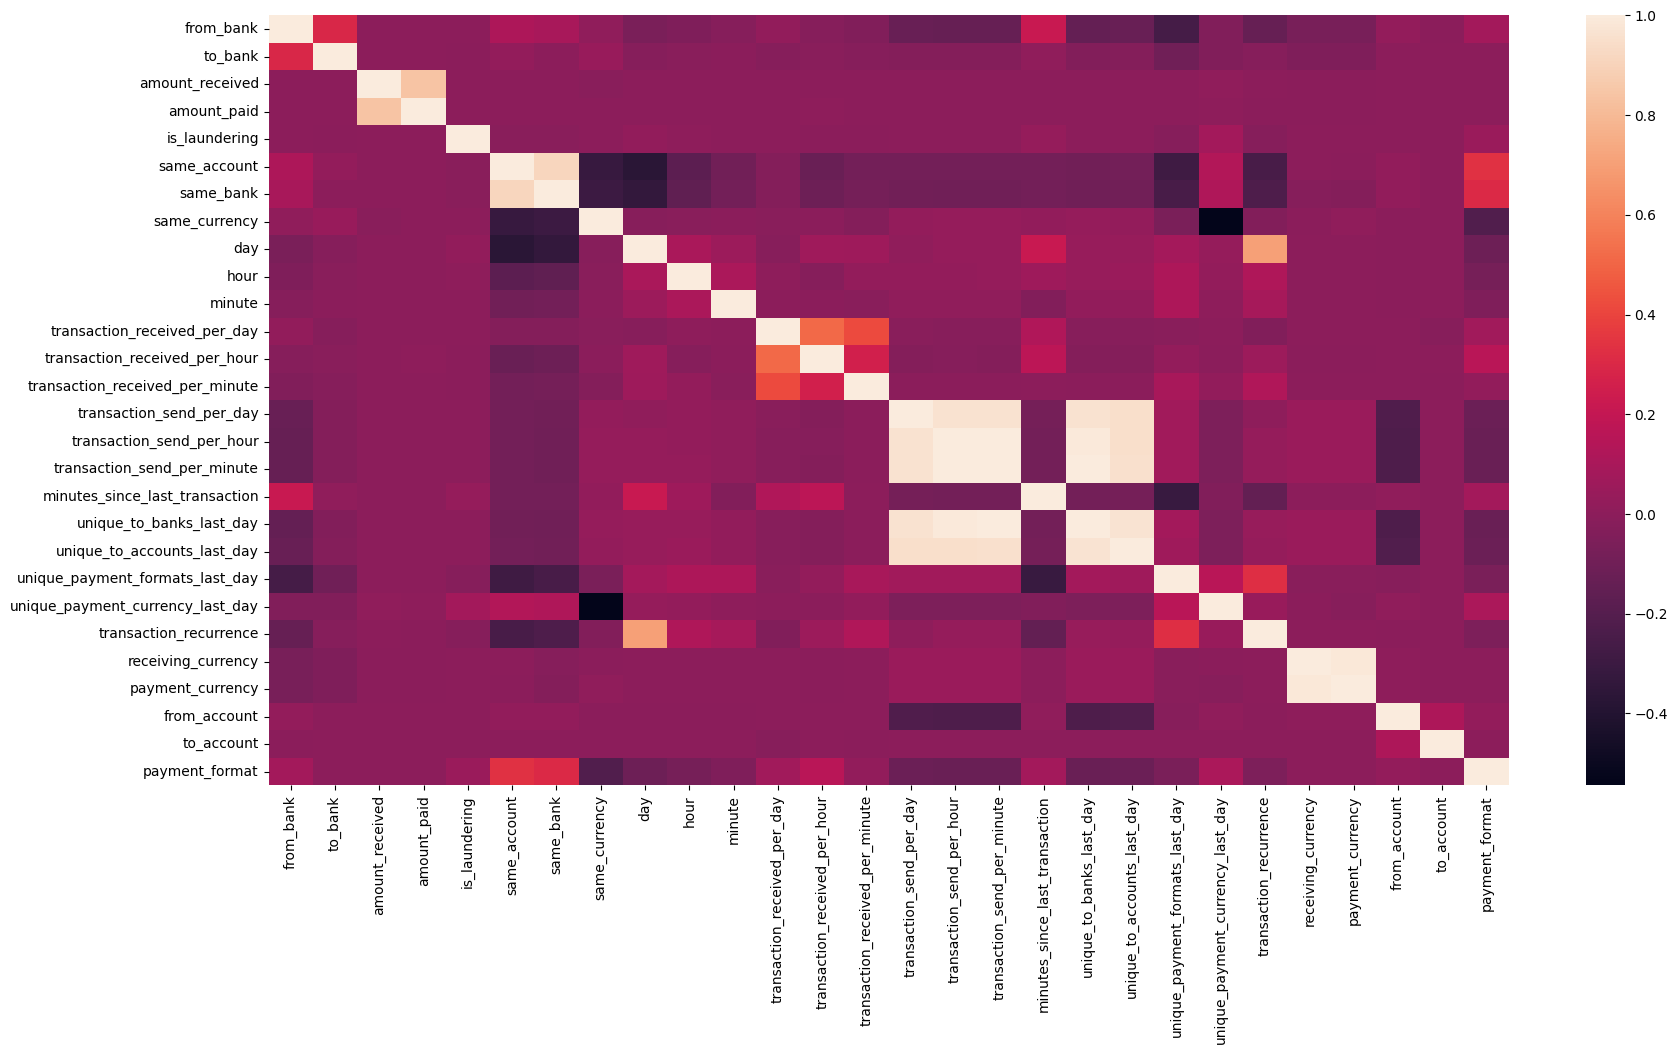

In [34]:
print_correlation(df.drop('timestamp').drop('index').drop('year').drop('month'))

The correlation matrix shows that there are no strong correlations between the labels and the features under consideration. Conversely, it can be observed that some features are closely correlated with each other, which could lead to data redundancy. Additionally, the increased number of features could complicate the model and cause overfitting. However, the strong correlations are addressed since a random forest learning model is used, which samples and selects different features for each tree.

## Save dataframe in parquet format

In [35]:
manager.save_on_disk(df, 'partial_results', 'parquet')

In [36]:
df.unpersist()
del df
gc.collect()

10391

# Data Organization and Pre-processing

In this section, we will split the dataset to train and test the models. The chosen division is 60% for the Training set, 20% for the Validation set (for hyperparameter tuning), and 20% for the Test set. This division was suggested by the description provided on the Kaggle website regarding this dataset.

Once the dataset is divided, we will perform data preprocessing. As a result, features that are not useful for prediction will be removed, and finally, the various data sets will be saved for future use.

## Data splitting

As mentioned earlier, the data is divided into 60% for training, 20% for validation, and 20% for testing.

Before performing the split, the data is sorted by timestamp and then divided sequentially. Typically, this procedure wouldn't be followed. However, it's done this way because the logic of the transactions is based on time, and many features are connected to it. If the data were taken randomly, the temporal features would become much less significant.


In [ ]:
df = spark.read.parquet('partial_results/df.parquet')
ordered_df = df.orderBy("timestamp")

ordered_df.cache()

# Calculate row counts for splits
total_rows = ordered_df.count()
train_rows, validation_rows = int(total_rows * 0.6), int(total_rows * 0.2)
test_rows = total_rows - train_rows - validation_rows

# Add a dummy partition and assign row numbers based on ordered timestamps
w = Window.partitionBy(lit(1)).orderBy("timestamp")
ordered_df = ordered_df.withColumn("row_number", F.row_number().over(w))

# Split and repartition the DataFrame into train, validation, and test sets based on row numbers
train_df = ordered_df.filter(col("row_number") <= train_rows).drop("row_number", "dummy_partition").repartition(32)
validation_df = ordered_df.filter(col("row_number").between(train_rows + 1, train_rows + validation_rows)).drop("row_number", "dummy_partition").repartition(32)
test_df = ordered_df.filter(col("row_number") > train_rows + validation_rows).drop("row_number", "dummy_partition").repartition(32)

## Calculate features over splitted data and save

In this section, I will perform pre-processing on the data. Hence, all necessary features used for the analysis are calculated, and features deemed unimportant are removed.

In this case, the removed features are the sending and receiving banks, as they are expected to be of minor significance in a system where, perhaps, the model is trained on specific types of banks and then used to predict data where the same banks don't appear. The reasoning is the same for the sending and receiving account. Furthermore, it was decided to remove the amounts since the initial analyses showed them to be of little utility and quite random.

Index and timestamp are removed as they are unnecessary for training and using the model.

In [48]:
train_df = manager.add_features(train_df)

test_df = manager.add_features(test_df)

validation_df = manager.add_features(validation_df)

## Feature selection

The previously saved datasets contain a large number of features, but not necessarily all these features are useful for a good predictive model. For this reason, I decided to use a feature selection technique called Boruta.

Boruta is a feature selection algorithm for random forest-based models. It identifies and retains the most important features for prediction while eliminating irrelevant or redundant ones. Boruta operates by comparing the importance of the original features with that of random "shadow" features. If an original feature is deemed less important than a shadow feature, it's considered irrelevant and removed.

In [49]:
!pip install boruta
if not skip_boruta:

    from boruta import BorutaPy
    from sklearn.ensemble import RandomForestClassifier

    manager = Manager()
    
    manager.save_on_disk(train_df.sample(withReplacement=False, fraction=0.1, seed=0), 'partial_results', 'train_boruta')

    #save to parquet
    train_pd = pd.read_parquet('./partial_results/df.train_boruta')

    X_train = train_pd.drop('is_laundering', axis=1)
    y_train = train_pd['is_laundering']

In [50]:
if not skip_boruta:

    rf = RandomForestClassifier(n_jobs=-1, class_weight='balanced_subsample', n_estimators=10, random_state=0)

    boruta_selector = BorutaPy(rf, n_estimators='auto', random_state=0, max_iter=50)

    boruta_selector.fit(np.array(X_train.values), np.array(y_train.values.ravel()))

    X_train_selected = boruta_selector.transform(X_train.values)

In [51]:
if not skip_boruta:
    selected_features = X_train.columns[boruta_selector.support_]
    removed_features = X_train.columns[[True if x == False else False for x in boruta_selector.support_]]
    print("Selected Features:", selected_features)
    print("Removed Features:", removed_features)

Selected Features: Index(['same_account', 'same_bank', 'day', 'minute',
       'transaction_received_per_day', 'transaction_received_per_hour',
       'transaction_send_per_day', 'transaction_send_per_hour',
       'transaction_send_per_minute', 'minutes_since_last_transaction',
       'unique_to_banks_last_day', 'unique_to_accounts_last_day',
       'unique_payment_formats_last_day', 'unique_payment_currency_last_day',
       'transaction_recurrence', 'payment_format'],
      dtype='object')
Removed Features: Index(['same_currency', 'hour', 'transaction_received_per_minute',
       'receiving_currency', 'payment_currency'],
      dtype='object')


Boruta has selected five features that it deems unnecessary, so I will remove them from the data sets. It's noteworthy that among the unselected features is 'same_currency', which from the preliminary analysis appeared to be of little significance.

In [52]:
def mantain_boruta_selected_features(df, name, features):
    features_to_select = list(selected_features)
    features_to_select.append('is_laundering')
    manager.save_on_disk(df.select(*features_to_select), 'processed_data', name)

In [53]:
mantain_boruta_selected_features(train_df, 'train', selected_features)
mantain_boruta_selected_features(test_df, 'test', selected_features)
mantain_boruta_selected_features(validation_df, 'val', selected_features)


In [ ]:

import gc
del ordered_df, train_df, test_df, validation_df, df
gc.collect()

# Decision Tree Classifier

At this point, it's possible to implement the decision tree from scratch. A Decision Tree Classifier is a supervised learning algorithm that uses a tree structure to make decisions. Each node of the tree represents a question or a condition about the data, while each branch represents a possible outcome of that question. The leaves of the tree represent the final classifications of the data. The algorithm learns how to split the data based on features to produce the most accurate decisions/classifications possible.

The tree will initially be tested using sample data taken from the scikit-learn library. For this purpose, I have chosen to use the Breast Tumor dataset as it presents a binary classification and a large number of features, allowing for testing the tree's effectiveness. It will then be compared to the decision tree classifier available directly in the scikit-learn library.

## Implementation of the tree from scratch



In [18]:
class DTC():
    def __init__(self, random_state = None, max_depth = None, min_sample_split = 2, criterion = "gini", min_info_gain = 0, max_features = None, max_thresholds = None, class_weights = {}, verbose=False):
        """
        Initializes the Decision Tree Classifier.

        Parameters:
        - random_state: int or None, optional (default=None)
            Seed for the random number generator.
        - max_depth: int or None, optional (default=None)
            The maximum depth of the decision tree. If None, the tree is grown until all leaves are pure or until all leaves contain fewer than min_sample_split samples.
        - min_sample_split: int, optional (default=2)
            The minimum number of samples required to split an internal node.
        - criterion: str, optional (default="gini")
            The function to measure the quality of a split. Supported criteria are "gini" for the Gini impurity, "entropy" for the information gain, and "shannon" for the Shannon entropy.
        - min_info_gain: float, optional (default=0)
            The minimum information gain required to split an internal node.
        - max_features: int, float, "sqrt", "log2", or None, optional (default=None)
            The number of features to consider when looking for the best split.
        - max_thresholds: int or None, optional (default=None)
            The maximum number of thresholds to consider for each feature when looking for the best split.
        - class_weights: dict, optional (default={})
            Weights associated with classes in the form {class_label: weight}. If provided, the class probabilities are multiplied by the corresponding weight.

        Returns:
        None
        """

        self.max_depth = max_depth
        self.min_sample_split = min_sample_split
        self.criterion = criterion
        self.min_info_gain = min_info_gain
        self.max_features = max_features
        self.max_thresholds = max_thresholds
        self.class_weights = class_weights
        self.tree = None
        self.random_state = random_state
        np.random.seed(self.random_state)
        self.node_counter = 0
        self.verbose = verbose



    def fit(self, X, y):
        """
        Fits the decision tree classifier to the training data.

        Parameters:
        - X: array-like of shape (n_samples, n_features)
            The training input samples.
        - y: array-like of shape (n_samples,)
            The target values.

        Returns:
        None
        """
        self.node_counter = 0
        if isinstance(X, pd.DataFrame):
            X = np.array(X)
        if isinstance(y, pd.DataFrame):
            y = np.array(y)

        self.tree = self.__create_tree(X, y)

    def __calculate_split_entropy(self, y):
        """
        Calculates the split entropy for a given target variable.

        Parameters:
        - y: array-like of shape (n_samples,)
            The target values.

        Returns:
        split_criterion: float
            The split criterion value.
        """

        unique_values, value_counts = np.unique(y, return_counts=True)
        class_probabilities = value_counts / len(y)

        if len(self.class_weights) > 0 and len(unique_values) > 0:
            class_probabilities *= np.array([self.class_weights.get(value, 1.0) for value in unique_values])

        split_criteria = {
            'shannon': lambda probs: -np.sum(probs * np.log2(probs)),
            'entropy': lambda probs: -np.sum(probs * np.log2(probs + 1e-10)),
            'gini': lambda probs:  1 - np.sum(probs ** 2)
        }

        split_criterion_function = split_criteria.get(self.criterion, split_criteria['gini'])
        split_criterion = split_criterion_function(class_probabilities)

        return split_criterion


    def __calculate_info_gain(self, X, y, feature, threshold):
        """
        Calculates the information gain for a given feature and threshold.

        Parameters:
        - X: array-like of shape (n_samples, n_features)
            The input samples.
        - y: array-like of shape (n_samples,)
            The target values.
        - feature: int
            The index of the feature.
        - threshold: float
            The threshold value.

        Returns:
        info_gain: float
            The information gain.
        """

        left_indeces = X[:, feature] <= threshold
        right_indeces = X[:, feature] > threshold

        left_labels = y[left_indeces]
        right_labels = y[right_indeces]

        left_side_entropy = self.__calculate_split_entropy(left_labels)
        right_side_entropy = self.__calculate_split_entropy(right_labels)


        weighted_left_side_entropy = (len(left_labels) / len(y)) * left_side_entropy
        weighted_right_side_entropy = (len(right_labels) / len(y)) * right_side_entropy

        parent_entropy = self.__calculate_split_entropy(y)

        info_gain = parent_entropy - (weighted_left_side_entropy + weighted_right_side_entropy)

        return info_gain


    def __get_features(self, n_features):
        """
        Returns the indices of the features to consider for splitting.

        Parameters:
        - n_features: int
            The total number of features.

        Returns:
        columns_id: list
            The indices of the features to consider.
        """

        np.random.seed(self.random_state + self.node_counter if self.random_state is not None else None)
        if self.max_features is not None:
            if self.max_features == "sqrt":
                columns_id = np.random.choice(range(n_features), int(math.sqrt(n_features)), replace=False)
            elif self.max_features == "log2":
                columns_id = np.random.choice(range(n_features), int(math.log2(n_features)), replace=False)
            elif isinstance(self.max_features, int):
                if self.max_features > n_features:
                    raise ValueError("Max features > number of features")
                elif self.max_features <= 0:
                    raise ValueError("Max features must be > 0")
                columns_id = np.random.choice(range(n_features), self.max_features, replace=False)
            elif isinstance(self.max_features, float):
                if self.max_features > 1:
                    raise ValueError("Max features > number of features")
                elif self.max_features <= 0:
                    raise ValueError("Max features must be > 0")
                columns_id = np.random.choice(range(n_features), int(n_features * self.max_features), replace=False)
        else:
            columns_id = list(range(n_features))

        return columns_id


    def __get_thresholds(self, X, feature):
        """
        Returns the thresholds to consider for a given feature.

        Parameters:
        - X: array-like of shape (n_samples, n_features)
            The input samples.
        - feature: int
            The index of the feature.

        Returns:
        thresholds: array-like
            The thresholds to consider.
        """
        np.random.seed(self.random_state + self.node_counter if self.random_state is not None else None)
        if self.max_thresholds is not None:
            if self.max_thresholds <= 0:
                raise ValueError("max_thresholds must be > 0")
            thresholds = np.percentile(X[:, feature], np.linspace(0, 100, self.max_thresholds))
        else:
            unique_vals = np.unique(X[:, feature])
            thresholds = (unique_vals[1:] + unique_vals[:-1]) / 2
        return thresholds



    def __calculate_best_split(self, X, y):
        """
        Calculates the best split for the given input samples and target values.

        Parameters:
        - X: array-like of shape (n_samples, n_features)
            The input samples.
        - y: array-like of shape (n_samples,)
            The target values.

        Returns:
        best_feature: int
            The index of the best feature to split on.
        best_threshold: float
            The best threshold value.
        best_info_gain: float
            The information gain of the best split.
        """

        best_threshold = None
        best_info_gain = -np.inf
        best_feature = None
        self.node_counter += 1
        features = self.__get_features(X.shape[1])

        for feature in features:
            threholds = self.__get_thresholds(X, feature)

            for threshold in threholds:
                info_gain = self.__calculate_info_gain(X, y, feature, threshold)
                if best_info_gain < info_gain:
                    best_threshold = threshold
                    best_feature = feature
                    best_info_gain = info_gain

        return best_feature, best_threshold, best_info_gain


    def __create_tree(self, X, y, depth = 0):
        """
        Recursively creates the decision tree.

        Parameters:
        - X: array-like of shape (n_samples, n_features)
            The input samples.
        - y: array-like of shape (n_samples,)
            The target values.
        - depth: int, optional (default=0)
            The current depth of the tree.

        Returns:
        tree: dict
            The decision tree.
        """
        samples = X.shape[0]

        if samples < self.min_sample_split or (self.max_depth != None and depth >= self.max_depth):
            return self.__create_leaf_node(y)

        best_feature, best_threshold, best_info_gain = self.__calculate_best_split(X, y)

        if(best_info_gain <= self.min_info_gain):
            return self.__create_leaf_node(y)

        left_indices = X[:, best_feature] <= best_threshold
        right_indices = X[:, best_feature] > best_threshold

        left_child = self.__create_tree(X[left_indices], y[left_indices], depth + 1)
        right_child = self.__create_tree(X[right_indices], y[right_indices], depth + 1)

        if 'label' in left_child and 'label' in right_child:
            if left_child['label'] == right_child['label']:
                return {
                    'label': left_child['label'],
                    'samples': len(y)
                }


        return {
            'splitting_threshold': best_threshold,
            'splitting_feature': best_feature,
            'info_gain': best_info_gain,
            'left_child': left_child,
            'right_child': right_child
        }



    def __create_leaf_node(self, y):
        """
        Creates a leaf node for the decision tree.

        Parameters:
        - y: array-like of shape (n_samples,)
            The target values.

        Returns:
        leaf_node: dict
            The leaf node.
        """
        majority_class = Counter(y).most_common(1)[0][0]
        return {
            'label': majority_class,
            'samples': len(y)
        }


    def predict(self, X):
        """
        Predicts the class labels for the input samples.

        Parameters:
        - X: array-like of shape (n_samples, n_features)
            The input samples.

        Returns:
        predictions: array-like of shape (n_samples,)
            The predicted class labels.
        """

        if(isinstance(X, pd.DataFrame)):
            X = np.array(X)

        predictions = []
        for sample in X:
            prediction = self.__traverse_tree(sample, self.tree)
            predictions.append(prediction)
        return np.array(predictions)

    def calculate_metrics(self, y_true, y_pred):

        """
        Calculate performance metrics: precision, recall, f1-score, and accuracy.

        Parameters:
        - y_true: list, true class labels.
        - y_pred: list, predicted class labels by the model.

        Returns:
        - precision: float, precision metric.
        - recall: float, recall metric.
        - f1_score: float, f1-score metric.
        - accuracy: float, accuracy metric.
        """


        TP = 0
        TN = 0
        FP = 0
        FN = 0


        for true, pred in zip(y_true, y_pred):
            if true == 1 and pred == 1:
                TP += 1
            elif true == 0 and pred == 0:
                TN += 1
            elif true == 1 and pred == 0:
                FN += 1
            elif true == 0 and pred == 1:
                FP += 1


        precision = TP / (TP + FP) if (TP + FP) != 0 else 0
        recall = TP / (TP + FN) if (TP + FN) != 0 else 0
        f1_score = 2 * (precision * recall) / (precision + recall) if (precision + recall) != 0 else 0
        accuracy = (TP + TN) / (TP + TN + FP + FN)

        return precision, recall, f1_score, accuracy

    def score(self, X, y):

      """
      Compute and return the f1 score for the given test data and labels.

      Parameters:
      - X: pd.DataFrame or np.array
          Test data. Can be a DataFrame or a Numpy array.
      - y: pd.DataFrame or np.array
          True labels for the test data. Can be a DataFrame or a Numpy array.

      Returns:
      - float
          f1 score of the model on the given test data and labels.

      """

      if(isinstance(y, pd.DataFrame)):
          y = np.array(y)
      if(isinstance(X, pd.DataFrame)):
          X = np.array(X)


      y_pred = self.predict(X)


      return f1_score(y, y_pred)


    def __traverse_tree(self, sample, node):
        """
        Traverses the decision tree to predict the class label for a given sample.

        Parameters:
        - sample: array-like of shape (n_features,)
            The input sample.
        - node: dict
            The current node of the decision tree.

        Returns:
        label: int
            The predicted class label.
        """

        if 'label' in node:
            return node['label']
        else:
            if sample[node['splitting_feature']] <= node['splitting_threshold']:
                return self.__traverse_tree(sample, node['left_child'])
            else:
                return self.__traverse_tree(sample, node['right_child'])

    def __recursive_print(self, node, indent=""):
        """Recursively print the decision tree.

        Parameters
        ----------
        node
            The current node to be printed.
        indent : str, default=""
            The indentation string for formatting the tree.
        """
        if 'label' in node:
            print("{}leaf - label: {} ".format(indent, node['label']))
            return

        print("{}id:{} - threshold: {}".format(indent,
              node['splitting_feature'], node['splitting_threshold']))

        self.__recursive_print(node['left_child'], "{}   ".format(indent))
        self.__recursive_print(node['right_child'], "{}   ".format(indent))

    def print_tree(self):
        """Display the decision tree structure."""
        self.__recursive_print(self.tree)

## Test with scikit-learn library

In [56]:
from sklearn.datasets import load_breast_cancer
from sklearn.tree import DecisionTreeClassifier
from sklearn.model_selection import train_test_split

data = load_breast_cancer(as_frame=False)

X_train, X_test, y_train, y_test = train_test_split(np.array(data['data']), np.array(data['target']), test_size=0.2, random_state=0)

In [57]:
clf = DecisionTreeClassifier(random_state=0)
dtc = DTC(random_state=0)

In [58]:
clf.fit(X_train, y_train)
clf.score(X_test, y_test)

0.9122807017543859

In [59]:
dtc.fit(X_train, y_train)
dtc.score(X_test, y_test)

0.9122807017543859

## Hyperparameter Tuning

After implementing the tree, before testing it definitively on the data, I will perform hyperparameter tuning to maximize the model's performance. The tuning is done using the Hyperopt library, which trains and calculates the score on the validation set with different hyperparameter combinations.

In [111]:
from hyperopt import fmin, tpe, hp, Trials

train_pd = pd.read_parquet('./processed_data/df.train').sample(frac=0.5, random_state=0)
val_pd = pd.read_parquet('./processed_data/df.val').sample(frac=0.5, random_state=0)

X_train = np.array(train_pd.drop('is_laundering', axis=1))
y_train = np.array(train_pd['is_laundering'])

class_weights = {0: 1, 1: 1/(np.sum(y_train)/len(y_train))}

X_val = np.array(val_pd.drop('is_laundering', axis=1))
y_val = np.array(val_pd['is_laundering'])

The hyperparameter tuning will be performed by adding class weighting. This is because, in this way, balance is created between the classes when calculating the information gain.

In [60]:
if not skip_hyperparameter_tuning:

    def objective_function(params):
            dtc = DTC(**params, random_state=0, class_weights=class_weights, verbose=False)
            dtc.fit(X_train, y_train)
            return -dtc.score(X_val, y_val)


    choises = {
            'max_depth': [8, 9, 10, 11, 12, 13, 14, 15, 16],
            'min_sample_split': [6, 7, 8, 9, 10, 11, 12, 13, 14, 15],
            'criterion': ['gini', 'entropy', 'shannon'],
            'max_features': ['sqrt', 'log2'],
            'max_thresholds': [5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15]
        }

    space = {
        'max_depth': hp.choice('max_depth', choises['max_depth']),
        'min_sample_split': hp.choice('min_sample_split', choises['min_sample_split']),
        'criterion': hp.choice('criterion', choises['criterion']),
        'max_features': hp.choice('max_features', choises['max_features']),
        'max_thresholds': hp.choice('max_thresholds', choises['max_thresholds'])
    }

    trials = Trials()
    best = fmin(fn=objective_function, space=space, algo=tpe.suggest, max_evals=50, trials=trials)

100%|██████████| 50/50 [12:53<00:00, 15.46s/trial, best loss: -0.5430167597765364]


In [61]:
if not skip_hyperparameter_tuning:
    for key, value in best.items():
        print(f"{key}: {choises[key][value]}")

criterion: gini
max_depth: 10
max_features: log2
max_thresholds: 11
min_sample_split: 11


## Train and Test DTC


In [112]:
test_pd = pd.read_parquet('./processed_data/df.test').sample(frac=0.5, random_state=0)

X_test = np.array(test_pd.drop('is_laundering', axis=1))
y_test = np.array(test_pd['is_laundering'])

cls_m = DTC(random_state=0, class_weights=class_weights, max_thresholds = 11, criterion='gini', max_depth=10, min_sample_split=11, max_features='log2', verbose=True)
cls_m.fit(X_train, y_train)
y_pred = cls_m.predict(X_test)
precision, recall, f1_score, accuracy = cls_m.calculate_metrics(y_test, y_pred)
metrics = {
                'accuracy': accuracy,
                'recall': recall,
                'precision': precision,
                'f1_score': f1_score
            }

print(metrics)

{'accuracy': 0.9986531031793854, 'recall': 0.4837261503928171, 'precision': 0.6580152671755726, 'f1_score': 0.5575679172056921}


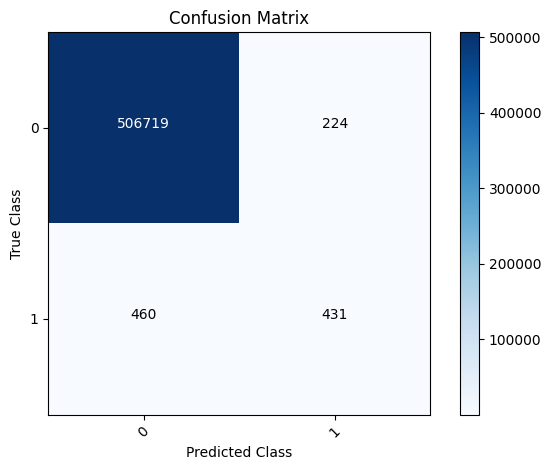

In [113]:
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix


cm = confusion_matrix(y_test, y_pred)


class_names = ['0', '1']


plt.imshow(cm, interpolation='nearest', cmap=plt.cm.Blues)
plt.title('Confusion Matrix')
plt.colorbar()

tick_marks = np.arange(len(class_names))
plt.xticks(tick_marks, class_names, rotation=45)
plt.yticks(tick_marks, class_names)


thresh = cm.max() / 2.0
for i in range(cm.shape[0]):
    for j in range(cm.shape[1]):
        plt.text(j, i, format(cm[i, j], 'd'),
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

plt.xlabel('Predicted Class')
plt.ylabel('True Class')
plt.tight_layout()
plt.show()

# Random Forest

The Random Forest is an algorithm that combines multiple decision trees to make more accurate predictions. Hence, what will be done in this section is to create a random forest from scratch using Spark. The idea is to generate the trees on different workers, thereby parallelizing the workload and speeding up the execution.

In [19]:
!git clone https://github.com/fabiobrambilla98/Joint_Project_AMD_SM2L.git

# Step 2: Navigate to the folder containing the Python file
%cd Joint_Project_AMD_SM2L

from DecisionTreeClassifier import DTC

In [20]:
class RandomForest():
    def __init__(self, n_estimators = 100, features_col = "feature", label_col = "label", min_sample_split = 2, criterion = "gini", max_depth = None, max_features = "sqrt", bootstrap = False, random_state = None, max_thresholds = None, verbose = 0):
        """
        Initializes the RandomForest classifier.

        Parameters:
        - n_estimators: int, number of trees in the forest.
        - features_col: str, name of the column containing features.
        - label_col: str, name of the column containing labels.
        - min_sample_split: int, minimum number of samples required to split a node.
        - criterion: str, function to measure the quality of a split.
        - max_depth: int, maximum depth of the tree.
        - max_features: str, number of features to consider when looking for the best split.
        - bootstrap: bool, whether bootstrap samples are used when building trees.
        - random_state: int, seed used by the random number generator.
        - max_thresholds: int, maximum number of thresholds to consider for each feature.
        - verbose: int, controls verbosity of output.
        """

        self.n_estimators = n_estimators
        self.criterion = criterion
        self.max_depth = max_depth
        self.max_features = max_features
        self.bootstrap = bootstrap
        self.random_state = random_state
        self.verbose = verbose
        self.trained_trees = []
        self.features_col = features_col
        self.label_col = label_col
        self.max_thresholds = max_thresholds
        self.min_sample_split = min_sample_split

        if self.random_state is not None:
            self.random_generator = np.random.RandomState(self.random_state)
        else:
            self.random_generator = None


    def __create_tree(self, partition_id, iterator):
        data = list(iterator)
        columns = list(data[0].__dict__.items())[0][1]
        df = pd.DataFrame(data, columns=columns).drop('id', axis=1)
        label_array = np.array(df[self.label_col])

        if self.random_generator:
            tree_random_state = self.random_state + partition_id
        else:
            tree_random_state = None


        clf = DTC(max_depth=self.max_depth, criterion=self.criterion, max_features=self.max_features,
                  random_state=tree_random_state, max_thresholds=self.max_thresholds,
                  class_weights={0: 1, 1: 1 / (np.sum(label_array) / len(label_array))}, min_sample_split = self.min_sample_split)

        clf.fit(np.array([x.toArray().tolist() for x in np.array(df[self.features_col])]), label_array)

        yield clf


    def fit(self, X):
        """
        Build a forest of trees from the training set (X).

        Parameters:
        - X: DataFrame, training data.
        """
        df = X.select(self.label_col, self.features_col)

        df_train = df

        if(self.bootstrap):
            df_train = df_train.sample(withReplacement=True, fraction=1.0, seed=self.random_state)

        df = df_train.withColumn("id", monotonically_increasing_id())

        df = df.repartition(self.n_estimators, "id")

        models = df.rdd.mapPartitionsWithIndex(self.__create_tree)
        self.trained_trees = models.collect()

    def __predict(self, index, iterator):
        data = list(iterator)
        columns = list(data[0].__dict__.items())[0][1]
        df = pd.DataFrame(data, columns=columns)
        predictions = []
        ids_table = np.array(df['id'])
        for model in self.trained_trees:
            predictions.append(model.predict(np.array(df.iloc[:,:-1])))

        n = len(predictions[0])

        most_frequent = []


        for i in range(n):
            values = [a[i] for a in predictions]
            counter = Counter(values)
            most_common = counter.most_common(1)[0]
            most_frequent.append(most_common[0])

        returning = list(zip(ids_table, most_frequent))


        yield returning

    def predict(self, X):
        """
        Predict class for X.

        Parameters:
        - X: DataFrame, input samples.

        Returns:
        - predictions: list, predicted class labels for samples in X.
        """
        df = X.withColumn("id", monotonically_increasing_id()).repartition(self.n_estimators, "id")
        models = df.rdd.mapPartitionsWithIndex(lambda index, iterator: self.__predict(index, iterator))
        collapsed_list = []
        for sublist in models.collect():
            collapsed_list.extend(sublist)
        sorted_list = [x[1] for x in sorted(collapsed_list, key=lambda x: x[0])]
        return sorted_list

    def calculate_metrics(self, y_true, y_pred):

        """
        Calculate performance metrics: precision, recall, f1-score, and accuracy.

        Parameters:
        - y_true: list, true class labels.
        - y_pred: list, predicted class labels by the model.

        Returns:
        - precision: float, precision metric.
        - recall: float, recall metric.
        - f1_score: float, f1-score metric.
        - accuracy: float, accuracy metric.
        """

        TP = 0
        TN = 0
        FP = 0
        FN = 0


        for true, pred in zip(y_true, y_pred):
            if true == 1 and pred == 1:
                TP += 1
            elif true == 0 and pred == 0:
                TN += 1
            elif true == 1 and pred == 0:
                FN += 1
            elif true == 0 and pred == 1:
                FP += 1


        precision = TP / (TP + FP) if (TP + FP) != 0 else 0
        recall = TP / (TP + FN) if (TP + FN) != 0 else 0
        f1_score = 2 * (precision * recall) / (precision + recall) if (precision + recall) != 0 else 0
        accuracy = (TP + TN) / (TP + TN + FP + FN)

        return precision, recall, f1_score, accuracy

In [9]:
train_df = spark.read.parquet('./processed_data/df.train')#.sample(False, fraction=0.5, seed=0)
test_df = spark.read.parquet('./processed_data/df.test')#.sample(False,fraction=0.5, seed=0)
val_df = spark.read.parquet('./processed_data/df.val')#.sample(False,fraction=0.5, seed=0)

In [21]:
from pyspark.ml.feature import VectorAssembler
rf = RandomForest(label_col="is_laundering", features_col="features", bootstrap=True, n_estimators=30, random_state=0, max_features="log2", max_thresholds=11)
assembler = VectorAssembler(inputCols=train_df.drop("is_laundering").columns, outputCol="features")
train = assembler.transform(train_df)
test = assembler.transform(test_df)
rf.fit(train)

In [23]:
test.cache()
y_true=np.array(test.select('is_laundering').collect()).squeeze()
rf.n_estimators = 100
y_pred = rf.predict(test_df.drop("is_laundering"))
precision, recall, f1_score, accuracy = rf.calculate_metrics(y_true, y_pred)
metrics = {
                'accuracy': accuracy,
                'recall': recall,
                'precision': precision,
                'f1_score': f1_score
            }

print(metrics)


23/08/29 19:48:58 WARN CacheManager: Asked to cache already cached data.


{'accuracy': 0.998749592633033, 'recall': 0.43548387096774194, 'precision': 0.7543352601156069, 'f1_score': 0.5521861777150917}


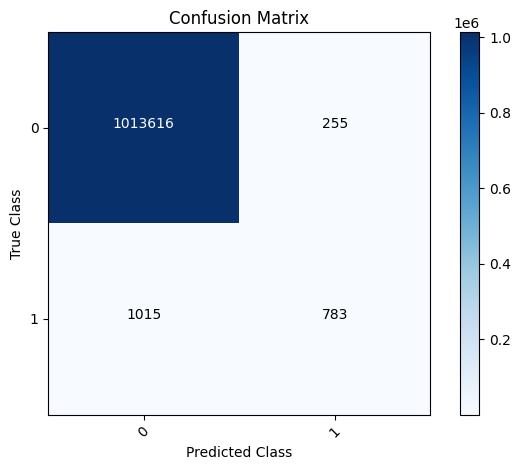

In [24]:
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix


cm = confusion_matrix(y_true, y_pred)


class_names = ['0', '1']


plt.imshow(cm, interpolation='nearest', cmap=plt.cm.Blues)
plt.title('Confusion Matrix')
plt.colorbar()

tick_marks = np.arange(len(class_names))
plt.xticks(tick_marks, class_names, rotation=45)
plt.yticks(tick_marks, class_names)

thresh = cm.max() / 2.0
for i in range(cm.shape[0]):
    for j in range(cm.shape[1]):
        plt.text(j, i, format(cm[i, j], 'd'),
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

plt.xlabel('Predicted Class')
plt.ylabel('True Class')
plt.tight_layout()
plt.show()
